In [4]:
#imports
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
#week 3
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
#week 4
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#week 5
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import nltk
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')

In [5]:
vg = pd.read_csv('../data/video_games.csv')

In [6]:
vg.head()

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_date,full_review
0,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,5,0,0,1,2015-08-31,amazing joystick I especially love twist Used ...
1,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,1,0,1,1,2015-08-31,One Star poor quality work advertised
2,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,3,0,0,1,2015-08-31,good could bettee nice tend slip away stick in...
3,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,4,0,0,1,2015-08-31,Great flawed Great amiibo great collecting Qua...
4,17521011,R2F0POU5K6F73F,B008XHCLFO,24234603,Protection for your 3DS XL,5,0,0,1,2015-08-31,A Must I 2012 2013 XL durable comfortable real...


In [7]:
vg['review_id'].value_counts() #confirming no duplicate reviews

R3SMTEMHJE303O    1
R3IKF0LYK155TY    1
R34YZUQ91WADPA    1
R3DUG1JOYCUNTE    1
R1INL03CXGF7OQ    1
                 ..
R2QNTZOM53OMG0    1
R3AX43HKDA54I8    1
R1E46B81AJHUTP    1
R3QWL83GR8U287    1
R2QK6PIIKMIK7U    1
Name: review_id, Length: 1648136, dtype: int64

In [8]:
vg.isnull().sum()

customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
star_rating           0
helpful_votes         0
total_votes           0
verified_purchase     0
review_date           0
full_review          47
dtype: int64

In [9]:
vg.dropna(inplace=True) #drop null values - these have no review text and are therefore useless to our model

In [10]:
vg['verified_purchase'].value_counts(normalize=True)

1    0.65529
0    0.34471
Name: verified_purchase, dtype: float64

Baseline accuracy will be 65.5% (predicting all reviews as coming from verified purchases). We'll see if I can predict any better through NLP.

First I'll drop columns that aren't relevant to this project - in order to simplify and save memory.

In [11]:
vg = vg[['verified_purchase', 'full_review']]

In [12]:
vg.head()

,verified_purchase,full_review
0,1,amazing joystick I especially love twist Used ...
1,1,One Star poor quality work advertised
2,1,good could bettee nice tend slip away stick in...
3,1,Great flawed Great amiibo great collecting Qua...
4,1,A Must I 2012 2013 XL durable comfortable real...


First thing to do as always is a good train test split - I'll stratify to be sure I get equal representation of the positive and negative class in both training and test sets.

In [13]:
X = vg['full_review']
y = vg['verified_purchase']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=17, stratify=y)

In [15]:
#check shapes
print(f''' 
{X_train.shape},
{y_train.shape},
{X_test.shape},
{y_test.shape}
''')

 
(1236066,),
(1236066,),
(412023,),
(412023,)



For the modeling, I'm going to borrow some functions I wrote during the Reddit NLP project I did previously.

In [16]:
def pipemaker(scaler, classifier):
    if scaler == 'cvec':
        item1 = ('cvec', CountVectorizer())
    elif scaler == 'tvec':
        item1 = ('tvec', TfidfVectorizer())
    else:
        return 'Error. Please enter "cvec" or "tvec"'
    if classifier == 'nb':
        item2 = ('nb', MultinomialNB())
    elif classifier == 'rf':   #added for model 10
        item2 = ('rf', RandomForestClassifier())
    elif classifier == 'logreg':#updated for model 12
        item2 = ('logreg', LogisticRegression())
    else:
        return 'Error.'
    return Pipeline([item1, item2])

In [17]:
def set_params(scaler, max_feat_list, min_df_list, max_df_list, sw_list, ngram_list):
    if scaler == 'cvec' or scaler == 'tvec':
        pipe_params = {f'{scaler}__max_features': max_feat_list,
                  f'{scaler}__min_df': min_df_list,
                  f'{scaler}__max_df': max_df_list,
                  f'{scaler}__stop_words': sw_list,
                  f'{scaler}__ngram_range': ngram_list}
    else:
        return "sorry, please use cvec or tvec"
    return pipe_params

In [18]:
def score_model(model, X_train, y_train, X_test, y_test):
    print(f'The best parameters are: {model.best_params_}')
    print(f'The best training score was: {model.best_score_}')
    print(f'The test score is: {model.score(X_test, y_test)}')
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print('_'*20)
    print('Confusion Matrix for Test Set:')
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d');
    plt.show()
    print(f'The Accurracy score is {metrics.accuracy_score(y_test, preds)}')
    print(f'The Sensitivity score is {metrics.recall_score(y_test, preds)}')
    print(f'The Precision score is {metrics.precision_score(y_test, preds)}')
    print('_'*20)
    print('Receiver Operating Characteristic (ROC) curve:')
    metrics.plot_roc_curve(model, X_test, y_test);
    plt.show()
    return 'Model scored!'

I'll start with a simple Naive Bayes model

In [19]:
import nltk
from nltk.corpus import stopwords

In [21]:
maxfeats = [5_000] #try different volume of features
mindf = [2] #minimum word frequency to be included in the model
maxdf = [1.0, .95] #cutoff for words more frequent than percentage (float) threshhold
ngrams = [(1,1), (1,2)] #range of combinations of words to try (minimum, maximum)
swords = [None] #stop words were removed during data cleaning! (see first nextale project for details)
scaler = 'cvec'
classifier = 'nb'

pipe = pipemaker(scaler, classifier)
params = set_params(scaler, maxfeats, mindf, maxdf, swords, ngrams)

gs = GridSearchCV(pipe, params, #load hyperparameters
                  n_jobs=8,        #use 8 cores to process faster
                  cv=3, verbose=1) #using 3 folds (speed) and lower verbose to limit messages returned

gs.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  12 | elapsed:  4.6min remaining:   55.6s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:  4.8min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=8,
             param_grid={'cvec__max_df': [1.0, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None]},
             verbose=1)

The best parameters are: {'cvec__max_df': 1.0, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}
The best training score was: 0.7672187407468533
The test score is: 0.7685735990466551
____________________
Confusion Matrix for Test Set:


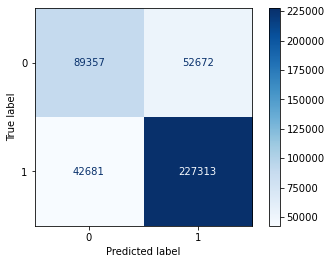

The Accurracy score is 0.7685735990466551
The Sensitivity score is 0.8419187093046512
The Precision score is 0.8118756361947962
____________________
Receiver Operating Characteristic (ROC) curve:


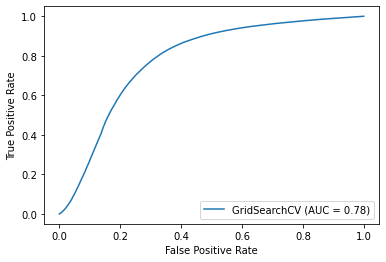

'Model scored!'

In [22]:
score_model(gs, X_train, y_train, X_test, y_test)

That's a decent starting point - 77% accuracy, well above baseline. I'm having difficulty running the grid search over too many parameters because it's just about crashing my computer! I'm going to try some other models to see how they look - I can return to the Naive Bayes method if it seems superior to the others.

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed: 21.2min finished


The best parameters are: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'logreg__C': 1, 'logreg__max_iter': 1000, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
The best training score was: 0.7859297157271538
The test score is: 0.7875361326916216
____________________
Confusion Matrix for Test Set:


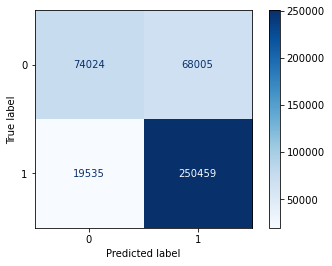

The Accurracy score is 0.7875361326916216
The Sensitivity score is 0.927646540293488
The Precision score is 0.7864593800241158
____________________
Receiver Operating Characteristic (ROC) curve:


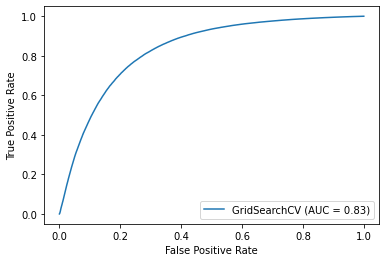

'Model scored!'

In [26]:
logreg = LogisticRegression()

pipe_logreg_params = {
    'logreg__penalty': ['l1','l2'], #try ridge and lasso
    'logreg__solver':['liblinear'],  #change solver to handle l1 and l2
    'logreg__max_iter': [1000], #more time to search for gradient descent
    'logreg__C': [1, .1, 10]} #try different alphas

maxfeats = [5_000] #try different volume of features
mindf = [2] #minimum word frequency to be included in the model
maxdf = [1.0, .9] #cutoff for words more frequent than percentage (float) threshhold 
ngrams = [(1,1)] #range of combinations of words to try (minimum, maximum) 
swords = [None]
scaler = 'cvec' #continuing with cvec
classifier = 'logreg' #<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW CLASSIFIER, Logreg

pipe = pipemaker(scaler, classifier)
params = set_params(scaler, maxfeats, mindf, maxdf, swords, ngrams)
params.update(pipe_logreg_params) #<<<<<<<<<<<<<<<<<<<<concatenate my two parameter dictionaries
gs = GridSearchCV(pipe, params, #load hyperparameters
                  n_jobs=8,        #<<<<<<<<<<<<<<<  8 cores
                  cv=3, verbose=1) #<<<<<<<<<<<<< 3 folds

gs.fit(X_train, y_train)

score_model(gs, X_train, y_train, X_test, y_test)

Interesting, a slight improvement (1-2%) over the Naive Bayes model. Let's see how a Random Forest does.

In [20]:
pipe_rf_params = {
    'rf__n_estimators': [125], #number of trees in my forest
    'rf__min_samples_split':[2],  #min number of samples required before a split
    'rf__min_samples_leaf': [1], #min number of samples that can be on one leaf
    'rf__max_features': ['auto'], #None performs like a tranditional bagging model, auto is sqrt of features
    'rf__max_depth': [7], #regulate depth of tree branches to combat overfit by not going too deep
    'rf__random_state': [17] #set random state
}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  3.0min finished


The best parameters are: {'cvec__max_df': 1.0, 'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 125, 'rf__random_state': 17}
The best training score was: 0.7218546582464044
The test score is: 0.7191904335437584
____________________
Confusion Matrix for Test Set:


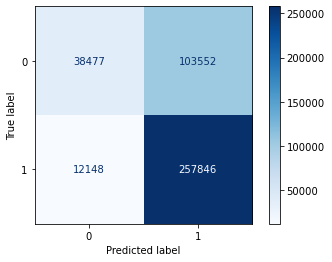

The Accurracy score is 0.7191904335437584
The Sensitivity score is 0.9550064075497974
The Precision score is 0.7134682538364905
____________________
Receiver Operating Characteristic (ROC) curve:


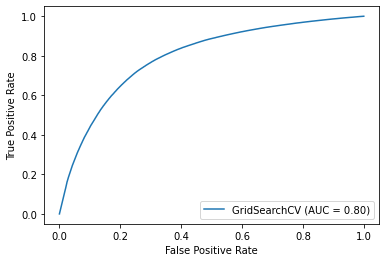

'Model scored!'

In [21]:
maxfeats = [5_000] #try different volume of features
mindf = [1] #minimum word frequency to be included in the model
maxdf = [1.0] #cutoff for words more frequent than percentage (float) threshhold 
ngrams = [(1,1)] #range of combinations of words to try (minimum, maximum) 
swords = [None]
scaler = 'cvec' #continuing with cvec
classifier = 'rf' #<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW CLASSIFIER, Random Forest

pipe = pipemaker(scaler, classifier)
params = set_params(scaler, maxfeats, mindf, maxdf, swords, ngrams)

params.update(pipe_rf_params) #<<<<<<<<<<<<<<<<<<<<concatenate my two parameter dictionaries

gs = GridSearchCV(pipe, params, #load hyperparameters
                  n_jobs=8,        #<<<<<<<<<<<<<<<CHANGE: upping to 10 cores
                  cv=3, verbose=1) #<<<<<<<<<<<<<CHANGE: reduced to 3 cv folds for faster processing

gs.fit(X_train, y_train)

score_model(gs, X_train, y_train, X_test, y_test)